In [1]:
!pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 12.4 MB/s 


In [82]:
import mahotas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image, ImageOps
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score, recall_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2

In [4]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


### **Load Images and Extract TAS Descriptors**

In [5]:
image_dir = "/gdrive/My Drive/Project/Denoised_CLAHE_Cl3"

In [6]:
def load_data(tag='train'):
  tag_dir = os.path.join(image_dir, tag)
  tag_path = Path(tag_dir)
  data = [] # Images
  cat = [] # Category
  subcat = []
  patient = []
  file_name = []
  for mag_dir in tag_path.iterdir():  
    mag_label = mag_dir.stem
    print("*",mag_label)
    if mag_label == "200X":
      print("Got it!")
      for img_name in mag_dir.glob('*.png'):
        img_label = img_name.stem
        splitted_image_name = img_label.split('_')
        cat_label = splitted_image_name[1]
        remaining_part = splitted_image_name[2].split('-')
        subcat_label = remaining_part[0]
        patient_label = remaining_part[2]
        img = mahotas.imread(img_name.as_posix())
        img = img[:, :, 0]
        feature = mahotas.features.pftas(img)
        data.append(feature) # append the feature to the data
        cat.append(cat_label) # append the label to the category
        subcat.append(subcat_label)
        patient.append(patient_label)
        file_name.append(img_label)
  return data, cat, subcat, patient, file_name

In [7]:
# train images
vec_train, cat_train, subcat_train, patient_train, image_name_train = load_data('train')
# test images
vec_test, cat_test, subcat_test, patient_test, image_name_test = load_data('test')

* 40X
* 100X
* 200X
Got it!
* 400X
* 40X
* 100X
* 200X
Got it!
* 400X


### **List the Categories**

In [8]:
# Get unique categories for train data
labels = list(np.unique(np.array(cat_train))) # convert categories to the numpy array and get unique values
labels

['B', 'M']

In [9]:
# Get unique categories for test data
labels = list(np.unique(np.array(cat_test)))
labels

['B', 'M']

In [10]:
# Get unique sub classes
list(np.unique(np.array(subcat_train)))

['A', 'DC', 'F', 'LC', 'MC', 'PC', 'PT', 'TA']

In [11]:
# Patients in the train set
len(list(np.unique(np.array(patient_train))))

54

In [12]:
# Patients in the test set
len(list(np.unique(np.array(patient_test))))

28

### **Label Encoding**

In [13]:
le = LabelEncoder()
label_train = le.fit_transform(cat_train) # Here fit is used to assign 0 or 1
label_test = le.transform(cat_test) # Only transform is used since the fit is already done above

In [14]:
label_train

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
label_test

### **Function to Compute Patient Recognition Rate**

In [16]:
def evaluate_recognition_rate(pred):
  inverted_prediction = le.inverse_transform(prediction)
  unique_patient_test = list(np.unique(np.array(patient_test)))
  num_images_per_patient = []
  num_correctly_classified = []
  num = 0
  total_patient_score = 0
  num_patient = 0
  for patient in unique_patient_test:
    num_patient = num_patient + 1
    Np = 0
    Nrec = 0
    image_index_counter = -1
    for image_name in image_name_test:
      image_index_counter = image_index_counter + 1
      image_name_splitted = image_name.split('-')
      if patient == image_name_splitted[2]:
        first_part_splitted = image_name_splitted[0].split('_')
        image_class = first_part_splitted[1]
        if image_class == inverted_prediction[image_index_counter]:
          Nrec = Nrec + 1
        Np = Np + 1
    patient_score = Nrec/Np
    #print(patient_score)
    num_images_per_patient.append(Np)
    num_correctly_classified.append(Nrec)
    total_patient_score = total_patient_score + patient_score
    num = num + Np    
  recognition_rate = total_patient_score/num_patient
  print("Summation of patient score: ", total_patient_score)
  print("Total Number of Patients: ", num_patient)
  print("Recognition Rate: ", recognition_rate)

### **SVM Fit**

In [83]:
pipe1 = Pipeline([
                 ("select",SelectKBest(chi2,k=30)),
                 ("scale", StandardScaler()),
                 ("classifier", SVC(class_weight='balanced', probability=True, kernel = 'rbf', gamma = 0.01, C = 100)) #radial basis function kernel
                 ])

In [84]:
pipe1.fit(vec_train,label_train)

Pipeline(steps=[('select',
                 SelectKBest(k=30,
                             score_func=<function chi2 at 0x7fd0f96cdd40>)),
                ('scale', StandardScaler()),
                ('classifier',
                 SVC(C=100, class_weight='balanced', gamma=0.01,
                     probability=True))])

**Accuracy**

In [85]:
# Test set evaluation
prediction = pipe1.predict(vec_test)
print('Accuracy: {0:5.2f}%'.format(accuracy_score(label_test,prediction)*100))

Accuracy: 78.09%


**Area Under Curve**

In [86]:
prediction_prob = pipe1.predict_proba(vec_test)
print("Area under curve (AUC): ", roc_auc_score(label_test, prediction_prob[:,1]))

Area under curve (AUC):  0.8451341272705402


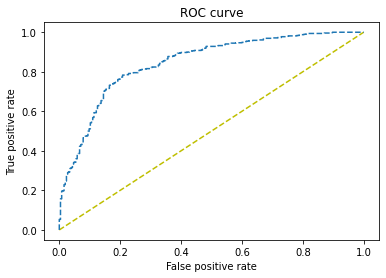

In [87]:
fpr, tpr, thresholds = roc_curve(label_test, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Patient Recognition Rate**

In [88]:
evaluate_recognition_rate(prediction)

Summation of patient score:  22.164761587881515
Total Number of Patients:  28
Recognition Rate:  0.7915986281386255


### **Random Forest**

In [117]:
pipe2 = Pipeline([
                 ("select",SelectKBest(chi2,k=30)),
                 ("scale", StandardScaler()),
                 ("classifier", RandomForestClassifier(class_weight='balanced', n_estimators = 50, random_state = 42))
                 ])

In [118]:
pipe2.fit(vec_train, label_train)

Pipeline(steps=[('select',
                 SelectKBest(k=30,
                             score_func=<function chi2 at 0x7fd0f96cdd40>)),
                ('scale', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=50, random_state=42))])

**Accuracy**

In [123]:
# Test set evaluation
prediction = pipe2.predict(vec_test)
print('Accuracy: {0:5.2f}%'.format(accuracy_score(label_test,prediction)*100))

Accuracy: 77.42%


**Area Under Curve**

In [124]:
prediction_prob = pipe2.predict_proba(vec_test)
print("Area under curve (AUC): ", roc_auc_score(label_test, prediction_prob[:,1]))

Area under curve (AUC):  0.8250330807169493


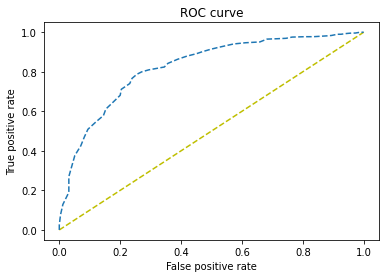

In [121]:
fpr, tpr, thresholds = roc_curve(label_test, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Patient Recognition Rate**

In [122]:
evaluate_recognition_rate(prediction)

Summation of patient score:  22.057243283400673
Total Number of Patients:  28
Recognition Rate:  0.7877586886928812


### **KNN**

In [145]:
pipe3 = Pipeline([
                 ("select",SelectKBest(chi2,k=30)), 
                 ("scale",StandardScaler()),
                 ("classifier", KNeighborsClassifier(n_neighbors=7))
                 ])

In [146]:
pipe3.fit(vec_train,label_train)

Pipeline(steps=[('select',
                 SelectKBest(k=30,
                             score_func=<function chi2 at 0x7fd0f96cdd40>)),
                ('scale', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=7))])

**Accuracy**

In [151]:
# Test set evaluation
prediction = pipe3.predict(vec_test)
print('Accuracy: {0:5.2f}%'.format(accuracy_score(label_test,prediction)*100))

Accuracy: 74.33%


**Area Under Curve**

In [148]:
prediction_prob = pipe3.predict_proba(vec_test)
print("Area under curve (AUC): ", roc_auc_score(label_test, prediction_prob[:,1]))

Area under curve (AUC):  0.782108344360239


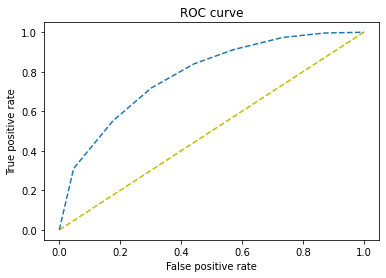

In [149]:
fpr, tpr, thresholds = roc_curve(label_test, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Patient Recognition Rate**

In [150]:
evaluate_recognition_rate(prediction)

Summation of patient score:  21.218855046171893
Total Number of Patients:  28
Recognition Rate:  0.7578162516489961


### **AdaBoost**

In [182]:
pipe4 = Pipeline([
                 ("classifier", AdaBoostClassifier(n_estimators=200, random_state=42))
                 ])

In [183]:
pipe4.fit(vec_train,label_train)

Pipeline(steps=[('classifier',
                 AdaBoostClassifier(n_estimators=200, random_state=42))])

**Accuracy**

In [184]:
# Test set evaluation
prediction = pipe4.predict(vec_test)
print('Accuracy: {0:5.2f}%'.format(accuracy_score(label_test,prediction)*100))

Accuracy: 71.91%


**Area Under Curve**

In [185]:
prediction_prob = pipe4.predict_proba(vec_test)
print("Area under curve (AUC): ", roc_auc_score(label_test, prediction_prob[:,1]))

Area under curve (AUC):  0.7297967039576566


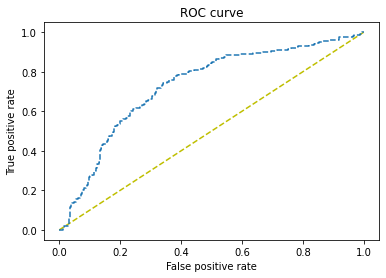

In [186]:
fpr, tpr, thresholds = roc_curve(label_test, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Patient Recognition Rate**

In [187]:
evaluate_recognition_rate(prediction)

Summation of patient score:  19.943563114253585
Total Number of Patients:  28
Recognition Rate:  0.7122701112233424


### **Xgboost**

In [222]:
"""
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)    
"""
pipe5 = Pipeline([
                 ("select",SelectKBest(chi2,k=30)), 
                 ("classifier", xgb.XGBClassifier(n_estimators=200))
                 ])
vec_train_arr = np.array(vec_train)
vec_test_arr = np.array(vec_test)
pipe5.fit(vec_train_arr, label_train)

Pipeline(steps=[('select',
                 SelectKBest(k=30,
                             score_func=<function chi2 at 0x7fd0f96cdd40>)),
                ('classifier', XGBClassifier(n_estimators=200))])

**Accuracy**

In [223]:
prediction = pipe5.predict(vec_test_arr)
print("Accuracy = ", accuracy_score(label_test, prediction))

Accuracy =  0.7526881720430108


**Area Under Curve**

In [224]:
prediction_prob = pipe5.predict_proba(vec_test_arr)
print("Area under curve (AUC): ", roc_auc_score(label_test, prediction_prob[:,1]))

Area under curve (AUC):  0.8014194634909177


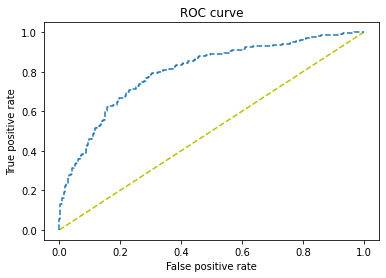

In [225]:
fpr, tpr, thresholds = roc_curve(label_test, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Patient Recognition Rate**

In [226]:
evaluate_recognition_rate(prediction)

Summation of patient score:  21.007928516309267
Total Number of Patients:  28
Recognition Rate:  0.7502831612967595


### **LightGBM**

In [227]:
scaler = StandardScaler()
vec_train_scaled = scaler.fit_transform(vec_train)
vec_test_scaled = scaler.transform(vec_test)
d_train = lgb.Dataset(vec_train_scaled, label=label_train)

In [228]:
lgbm_params = {'learning_rate':0.05, 'boosting_type':'gbdt', #Sometimes dart gives better accuracy. gbdt means gradient boosting.
              'objective':'binary',
              'metric':['auc', 'binary_logloss'],
              'num_leaves':100, # optimizing this avoids overfitting. 50 to 100
              'max_depth':10} #10 may be appropriate

In [241]:
clf = lgb.train(lgbm_params, d_train, 100) #50 iterations. Increase iterations for small learning rates. eg if learning grate = 0.005, we may need 500 iterations.
prediction=clf.predict(vec_test_scaled)
#convert the probabilities into binary values 0/1 for classification
for i in range(0, vec_test_scaled.shape[0]):
    if prediction[i]>=.5: # setting threshold to 0.5
       prediction[i]=1
    else:  
       prediction[i]=0

**Accuracy**

In [242]:
#Print accuracy
print ("Accuracy = ", accuracy_score(label_test, prediction))

Accuracy =  0.7620967741935484


**Area Under Curve**

In [243]:
prediction_prob=clf.predict(vec_test_scaled)
print("Area under curve (AUC): ", roc_auc_score(label_test, prediction_prob))

Area under curve (AUC):  0.8100324792493685


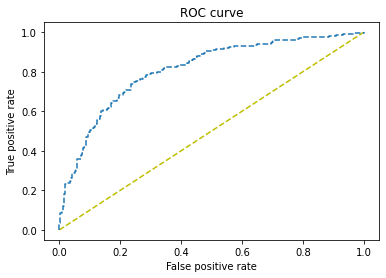

In [244]:
fpr, tpr, thresholds = roc_curve(label_test, prediction_prob) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Patient Recognition Rate**

In [245]:
prediction = prediction.astype(int)
evaluate_recognition_rate(prediction)

Summation of patient score:  21.150287708104248
Total Number of Patients:  28
Recognition Rate:  0.7553674181465803


### **Comparing lightgbm with xgboost by setting the same parameters**

In [246]:
dtrain=xgb.DMatrix(vec_train_scaled,label=label_train)

In [247]:
#setting parameters for xgboost
parameters={'max_depth':10, 
            'objective':'binary:logistic',
            'eval_metric':'auc',
            'learning_rate':.05}

In [248]:
xg=xgb.train(parameters, dtrain, 100)
dtest=xgb.DMatrix(vec_test_scaled)
prediction = xg.predict(dtest)

In [249]:
#Converting probabilities into 1 or 0  
for i in range(0, vec_test_scaled.shape[0]): 
    if prediction[i]>=.5: #Setting threshold to .5 
       prediction[i]=1 
    else: 
       prediction[i]=0  

print ("Accuracy with XGBoost = ", accuracy_score(label_test, prediction))
print("AUC score with XGBoost is: ", roc_auc_score(label_test, prediction))

Accuracy with XGBoost =  0.7580645161290323
AUC score with XGBoost is:  0.7071093468062072


### **Grid search to find the best model and parameters**

In [ ]:
skf = StratifiedKFold(n_splits = 5)

In [ ]:
# Defining a dictionary
model_params = {
    'svm': {
        'model': SVC(gamma='auto'),
        'params' : {
            'C': [0.1, 1, 5, 10, 100], #Regularization parameter.
            'kernel': ['rbf','linear','sigmoid','poly'], 
            'gamma':[0.00001,0.0001,0.001,0.01,0.1,1]
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [30,50,70,100] #Trees: may lead to overfitting if n_estimators is too much
        }
    },
    'KNN' : {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [1, 5, 9, 15, 19, 23, 27, 31, 35, 39]
        }
    }
}

In [ ]:
scores = []

for model_name, mp in model_params.items():
    grid =  GridSearchCV(estimator=mp['model'], 
                         param_grid=mp['params'], 
                         cv=skf, n_jobs=6, #five fold cross validation
                         return_train_score=False)
    
    grid.fit(vec_train,label_train)
    
    scores.append({
        'model': model_name,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_
    })

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])

print(df)

           model  best_score                               best_params
0            svm    0.746652  {'C': 100, 'gamma': 1, 'kernel': 'poly'}
1  random_forest    0.758103                      {'n_estimators': 50}
2            KNN    0.731526                        {'n_neighbors': 9}
